#  <font color='#57998f'>Natural Scenes - Multilabel Image Classification</font>

Current notebook is part of the final assignment in the context of **Deep Learning** course, <br> provided by MSc in Artificial Intelligence from NCSR Demokritos.
<br><br>

Dataset Reference:

[Image Data for Multi-Instance Multi-Label Learning](https://www.lamda.nju.edu.cn/data_MIMLimage.ashx)

Z.-H. Zhou and M.-L. Zhang. Multi-instance multi-label learning with application to scene classification. In: Advances in Neural Information Processing Systems 19 (NIPS'06) (Vancouver, Canada), B. Sch?lkopf, J. Platt, and T. Hofmann, eds. Cambridge, MA: MIT Press, 2007, pp.1609-1616.

  
<br><br>
> Chiotis Nikolaos - MTN2221 <br>
> chiotisn@yahoo.com <br>

<br><br>




##  <font color='#37665f'>Contents</font>


1.[Dataset Description](#Dataset-Description) <br>
2.[Requirements](#Requirements) <br>
3.[Read Dataset](#Read-Dataset) <br>
4.[Explore Dataset](#Explore-Dataset) <br>
5.[Train - Test Split](#Train---Test-Split) <br>
6.[Dummy Classifier](#Dummy-Classifier) <br>
7.[CNN Classifiers](#CNN-Classifiers) <br>
8.[Transfer Learning Classifier](#Transfer-Learning-Classifier)

<br>
<br>




##  <font color='#37665f'>Dataset Description</font>

The image data set consists of 2000 natural scene images, where a set of labels is artificially assigned to each image. The following table gives the detailed description of the number of images associated with different label sets, where all the possible class labels are **desert, mountains, sea, sunset and trees**. The number of images belonging to more than one class (e.g. sea+sunset) comprises over 22% of the data set, many combined classes (e.g. mountains+sunset +trees) are extremely rare.
<br><br>
Distribution of images per label:

| Label  Set       |            Num. of Images      |
| :-: | :-: |
|trees|378|
|sea|341|
|desert|340|
|mountains|268|
|sunset|216|
|sea+sunset|172|
|mountains+trees|106|
|mountains+sea|38|
|sunset+trees|28|
|desert+sunset|21|  
|desert+trees|20|
|desert+mountains|19|
|mountains+sunset|19|
|sea+trees|14|
|mountains+sea+trees|6|
|desert+sea|5|
|sea+sunset+trees|4|
|desert+sunset+trees|3|
|desert+mountains+sunset|1|
|mountains+sunset+trees|1|
          
        


   



<br> <br>

##  <font color='#37665f'>Requirements</font>

This project developed and executed using **Python 3**  in **Google Colab**.<br><br>

Dataset is saved in Google Drive, so we mount the drive folder in the Colab environment.

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


####  <font color='#37665f'>Libraries</font>

In [80]:
import os
import random
import scipy.io
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt
from scipy import ndimage


import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

from sklearn.metrics import *

sns.set_theme()

# seeds
np.random.seed(13)
random.seed(13)


<br> <br>

##  <font color='#37665f'>Read Dataset</font>

In [3]:
DATASET_PATH = '/content/drive/MyDrive/natural_scene_miml_image_data/'
IMG_PATH = os.path.join(DATASET_PATH, 'img')
MODELS_PATH = os.path.join(DATASET_PATH, 'models')

#### <font color='#425451'>Reading image filepaths & labels</font>

In [7]:
# read .mat file containing labels
mat = scipy.io.loadmat(os.path.join(DATASET_PATH, 'miml data.mat'))

# read label names
label_names = [i[0][0] for i in mat['class_name']]

# transform file in desired format
labels = mat['targets'].T
labels = [[label for label, truth in zip(label_names, row) if truth==1] for row in labels]

# dataframe of files and labels
files_df = pd.DataFrame({'filename':[str(a)+'.jpg' for a in range(1,2001,1)], 'labels': labels})

In [8]:
files_df.head(4)

filename               labels
0    1.jpg             [desert]
1    2.jpg             [desert]
2    3.jpg             [desert]
3    4.jpg  [desert, mountains]

<br> <br>

##  <font color='#37665f'>Explore Dataset</font>

In [7]:
# Number of labels
print('Dataset contains {} images.'.format(files_df.shape[0]))

Dataset contains 2000 images.


In [11]:
# Number of labels
labels = set([a for b in files_df['labels'] for a in b])
print('Dataset contains {} unique labels:'.format(len(labels)))
print(labels)

Dataset contains 5 unique labels:
{'sea', 'sunset', 'trees', 'desert', 'mountains'}


In [13]:
# Avg. number of labels
print('Images have {} labels in average.' \
      .format(len(list([a for b in files_df['labels'] for a in b]))/files_df.shape[0]))

Images have 1.236 labels in average.


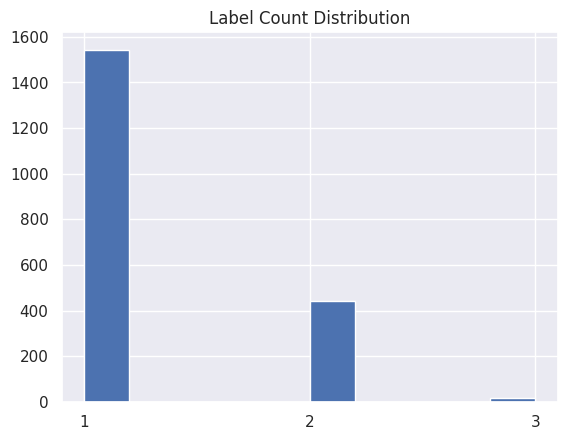

In [17]:
tmp = files_df.copy()
tmp['c'] = tmp['labels'].str.len().astype('str')
sns.set_theme()
tmp['c'].hist()
plt.title('Label Count Distribution')
plt.show()

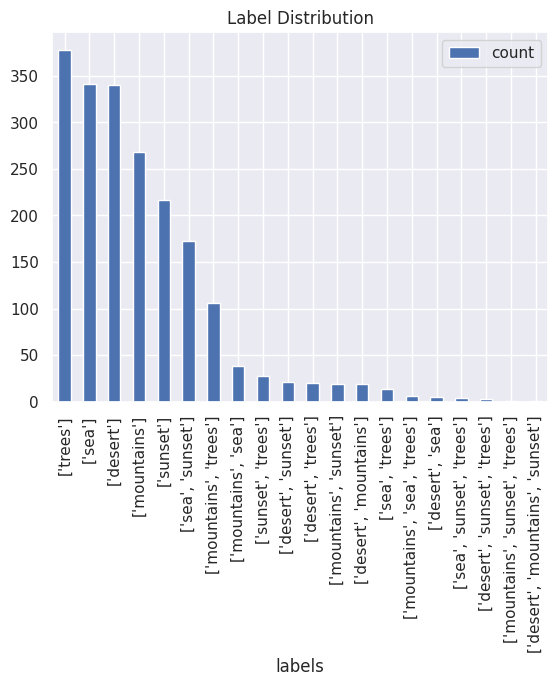

In [18]:
sns.set_theme()
tmp2 = tmp['labels'].astype('str').reset_index().groupby('labels').count().reset_index().sort_values('index', ascending=False).rename(columns={'index':'count'})
tmp2.plot(y='count', x='labels',kind='bar')
plt.xticks(rotation=90)
plt.title('Label Distribution')
plt.show()

<br> <br>

##  <font color='#37665f'>Train - Test Split</font>

In [9]:
test_perc = 0.2

id_test = random.sample(list(files_df.index),int(len(files_df.index)*test_perc))
id_train = [i for i in list(files_df.index) if i not in id_test]

df_test = files_df.iloc[id_test].reset_index(drop=True)
df_train = files_df.iloc[id_train].reset_index(drop=True)

print('Samples in train set: {}\nSamples in test set: {}'.format(df_train.shape[0],df_test.shape[0]))

Samples in train set: 1600
Samples in test set: 400


Creating Generators for training & testing

In [10]:
BATCH_SIZE = 16
EPOCHS = 100
IMG_SIZE = 128
CHANNELS = 3
N_LABELS = 5

In [11]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for validation data

train_generator = train_image_generator.flow_from_dataframe(dataframe=df_train,
                                                            directory=IMG_PATH,
                                                            x_col='filename',
                                                            y_col='labels',
                                                            class_mode='categorical',
                                                            shuffle=True,
                                                            target_size=(IMG_SIZE,IMG_SIZE),
                                                            batch_size=BATCH_SIZE,
                                                            seed=13)

test_generator = test_image_generator.flow_from_dataframe(dataframe=df_test,
                                                          directory=IMG_PATH,
                                                          x_col='filename',
                                                          y_col='labels',
                                                          class_mode='categorical',
                                                          shuffle=False,
                                                          target_size=(IMG_SIZE,IMG_SIZE),
                                                          batch_size=BATCH_SIZE,
                                                          seed=13)

Found 1600 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.


Plotting some train images

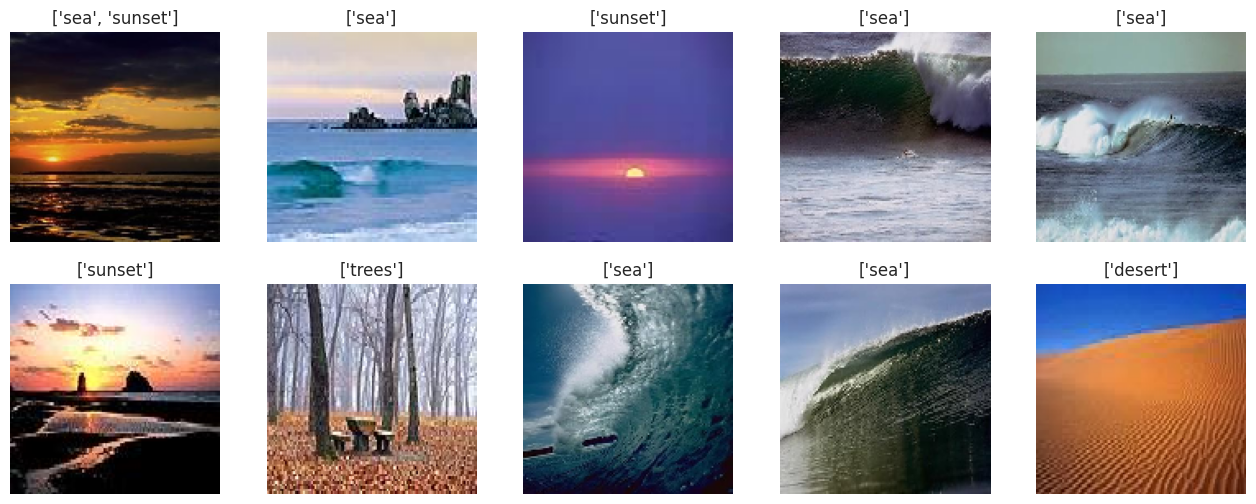

In [ ]:
plt.figure(figsize=(16,6))
for image, label in train_generator:
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(image[i])
        plt.title([label for label, truth in zip(label_names, label[i]) if truth==1])
        plt.axis('off')
    break

<br> <br>

##  <font color='#37665f'>Classifiers</font>

###  <font color='#37665f'>Dummy Classifier</font>

Creating a Dummy Classifier, in order to benchmark CNN classifiers

In [23]:
class CustomDummyClf:

    def __init__(self, random_seed=None):

        if random_seed != None:
            np.random.seed(random_seed)

    #y_train should be a Series containing true labels of X in a list.
    def fit(self, X_train, y_train):

        #number of records in the train set.
        size = len(X_train)

        #a list contains all labels used in y_train, without removing duplicates.
        self.label_list = list([a for b in y_train for a in b])

        #a list contains all labels used in y_train, without duplicates.
        self.labels = list(set([a for b in y_train for a in b]))
        self.labels.sort()

        self.mean_num_label = len(self.label_list)/size

    def get_random_labels(self):

        #  List label_list contains labels, each label apperring in list as many times is appeared in train set.
        #  So, by selecting randomly a label from this list, each label has possibility to be selected,
        #  equal to its appearance frequency in the train set.

        return np.random.choice(self.label_list, int(self.mean_num_label)).tolist()

    def predict(self, X_test):

        pred = pd.DataFrame(X_test).join(pd.DataFrame(columns=self.labels))
        pred = pred.fillna(0)

        #pred = pred.apply(lambda x: 1 if x.name in get_random_labels() else x, axis=0)

        for index, row in pred.iterrows():

            random_labels = self.get_random_labels()
            for i in random_labels:
                pred.loc[index,i] = 1

        y_test = pred.drop(columns='filename')

        return y_test

Scoring using dummy classifier

In [24]:
clf = CustomDummyClf()
clf.fit(df_train['filename'],df_train['labels'])
dummy_predictions = clf.predict(df_test['filename'])

In [27]:
dummy_predictions.head(3)

desert  mountains  sea  sunset  trees
0       0          0    0       0      1
1       0          0    1       0      0
2       0          1    0       0      0

###  <font color='#37665f'>Evaluation</font>

Create a function that transform list of labels to columns with 0/1 values. In order for the predictions to have same format as initial dataset.

In [12]:
def one_hot_enc(y):

    labels = list(set([a for b in y for a in b]))
    labels.sort()

    output = pd.DataFrame(y).join(pd.DataFrame(columns=labels))
    output = output.fillna(0)

    for index, row in output.iterrows():

        for i in row['labels']:
            output.loc[index,i] = 1

    output = output.drop(columns='labels')

    return output

In [29]:
y_truth = one_hot_enc(df_test['labels'])

In [32]:
print('Dummy Classifier evaluation:\n')
print(classification_report(y_true=y_truth, y_pred=dummy_predictions, target_names=label_names, zero_division=1))

Dummy Classifier evaluation:

              precision    recall  f1-score   support

      desert       0.22      0.16      0.19        85
   mountains       0.21      0.15      0.18        98
         sea       0.21      0.15      0.18       112
      sunset       0.21      0.19      0.20        83
       trees       0.31      0.29      0.30       115

   micro avg       0.24      0.19      0.21       493
   macro avg       0.23      0.19      0.21       493
weighted avg       0.23      0.19      0.21       493
 samples avg       0.24      0.19      0.21       493



<br> <br>
##  <font color='#37665f'>CNN Classifiers</font>

###  <font color='#37665f'>CNN with Convolutional & MaxPooling Layers</font>

We are creating a CNN with Conv2D alternating with MaxPooling2D layers.
The final output has the size of the labels (5), in order for the network to produce the possibility of each label.

We are not using softmax, like we were doing in a multiclass classification taks. Softmax transforms the values in a way that add up to 1, so the possibility of one class is dependent to others.

In multilabel classification, our labels are independent, so we treat each label output as a binary classification. For this reason, we are using sigmoid activation function. Also, since we want to calculate the loss function independently in each label, we are using binary crossentropy as a loss function.

In [34]:
model = Sequential([
          Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE ,CHANNELS)),
          MaxPooling2D(),
          Conv2D(64, (3,3), activation='relu'),
          MaxPooling2D(),
          Conv2D(128, (3,3), activation='relu'),
          MaxPooling2D(),
          Flatten(),
          Dense(64, activation='relu'),
          Dense(N_LABELS, activation='sigmoid')
          ])

model.compile('adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

During the fit of the model, we are creating a callback in order to save the model at the lowest point of validation loss.

In [35]:
check_point = keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODELS_PATH, 'model_1.h5'), monitor='val_loss', save_best_only=True)

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    callbacks=[check_point])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.4298 - binary_accuracy: 0.8083

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 667s 7s/step - loss: 0.4298 - binary_accuracy: 0.8083 - val_loss: 0.3416 - val_binary_accuracy: 0.8380
Epoch 2/100
100/100 [==============================] - 6s 57ms/step - loss: 0.3416 - binary_accuracy: 0.8556 - val_loss: 0.3435 - val_binary_accuracy: 0.8445
Epoch 3/100
100/100 [==============================] - 5s 55ms/step - loss: 0.3063 - binary_accuracy: 0.8667 - val_loss: 0.3169 - val_binary_accuracy: 0.8590
Epoch 4/100
100/100 [==============================] - 5s 53ms/step - loss: 0.2794 - binary_accuracy: 0.8815 - val_loss: 0.3148 - val_binary_accuracy: 0.8610
Epoch 5/100
100/100 [==============================] - 5s 51ms/step - loss: 0.2457 - binary_accuracy: 0.8955 - val_loss: 0.3249 - val_binary_accuracy: 0.8595
Epoch 6/100
100/100 [==============================] - 5s 48ms/step - loss: 0.2232 - binary_accuracy: 0.9084 - val_loss: 0.3485 - val_binary_accuracy: 0.8550
Epoch 7/100
100/100 [==============================] - 6s 59ms/s

Defining a function to plot Training & Validation Accuracy & Loss

In [13]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
      if smoothed_points:
          previous = smoothed_points[-1]
          smoothed_points.append(previous * factor + point * (1 - factor))
      else:
          smoothed_points.append(point)
  return smoothed_points

def plot_history_acc_loss(history):
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  fig,(ax2,ax1) = plt.subplots(1,2,figsize=(16,6))
  ax2.plot(epochs,smooth_curve(acc), '-', label='Smoothed training acc')
  ax2.plot(epochs,smooth_curve(val_acc), '-*', label='Smoothed validation acc')
  ax2.set_title('Training and validation binary accuracy')
  ax2.legend()

  ax1.plot(epochs,smooth_curve(loss), '-', label='Smoothed training loss')
  ax1.plot(epochs,smooth_curve(val_loss), '-*', label='Smoothed validation loss')
  ax1.set_title('Training and validation loss')
  ax1.legend()

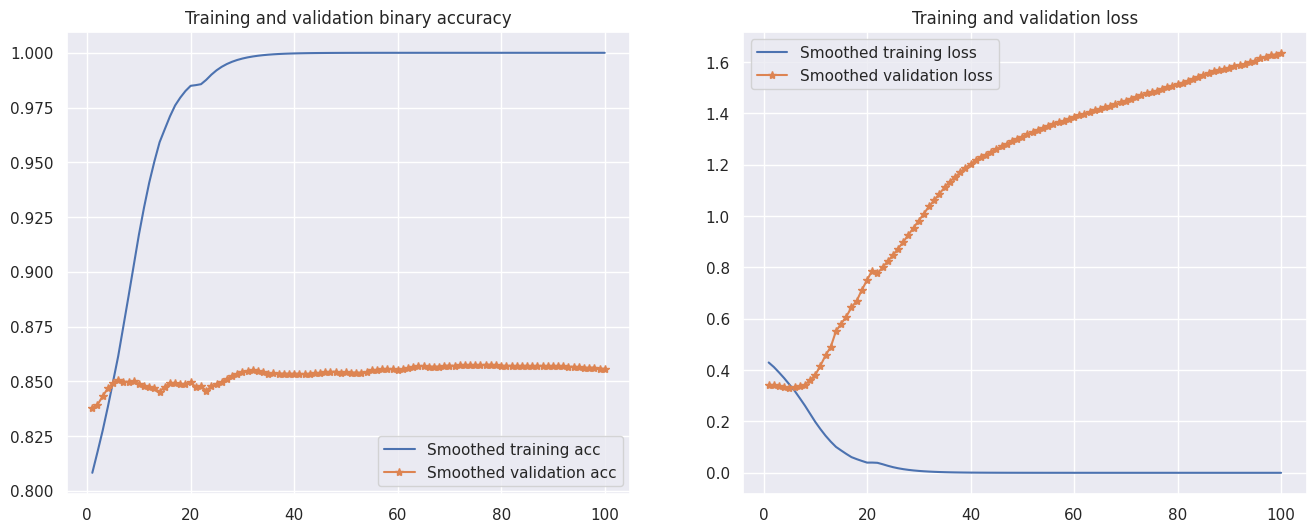

In [36]:
plot_history_acc_loss(history)

###  <font color='#37665f'>CNN adding Dropout & Early Stopping</font>

From the above plots, we can see that our model is not getting better in validation through epochs.

In order to reduce overfitting, we are also include **Dropout Layers** after each convolution.

Also, we are creating an **Early Stopping** callback, in order to stop training after validation loss is raising or is not improving through epochs.

In [37]:
model2 = Sequential([
          Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE ,CHANNELS)),
          MaxPooling2D(),
          Conv2D(64, (3,3), activation='relu'),
          Dropout(0.2),
          MaxPooling2D(),
          Conv2D(128, (3,3), activation='relu'),
          Dropout(0.2),
          MaxPooling2D(),
          Flatten(),
          Dense(64, activation='relu'),
          Dropout(0.1),
          Dense(N_LABELS, activation='sigmoid')
          ])

model2.compile('adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 61, 61, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)      

In [38]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
check_point = keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODELS_PATH, 'model_2.h5'), monitor='val_loss', save_best_only=True)

history2 = model2.fit(train_generator,
                      epochs=EPOCHS,
                      validation_data=test_generator,
                      callbacks=[early_stop, check_point])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.4560 - binary_accuracy: 0.7941

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 8s 62ms/step - loss: 0.4560 - binary_accuracy: 0.7941 - val_loss: 0.3700 - val_binary_accuracy: 0.8375
Epoch 2/100
100/100 [==============================] - 6s 60ms/step - loss: 0.3662 - binary_accuracy: 0.8431 - val_loss: 0.3738 - val_binary_accuracy: 0.8585
Epoch 3/100
100/100 [==============================] - 9s 91ms/step - loss: 0.3280 - binary_accuracy: 0.8589 - val_loss: 0.3476 - val_binary_accuracy: 0.8520
Epoch 4/100
100/100 [==============================] - 10s 95ms/step - loss: 0.2921 - binary_accuracy: 0.8771 - val_loss: 0.3392 - val_binary_accuracy: 0.8470
Epoch 5/100
100/100 [==============================] - 9s 94ms/step - loss: 0.2649 - binary_accuracy: 0.8870 - val_loss: 0.3237 - val_binary_accuracy: 0.8535
Epoch 6/100
100/100 [==============================] - 5s 48ms/step - loss: 0.2321 - binary_accuracy: 0.9064 - val_loss: 0.3470 - val_binary_accuracy: 0.8455
Epoch 7/100
100/100 [==============================] - 5s 54ms/

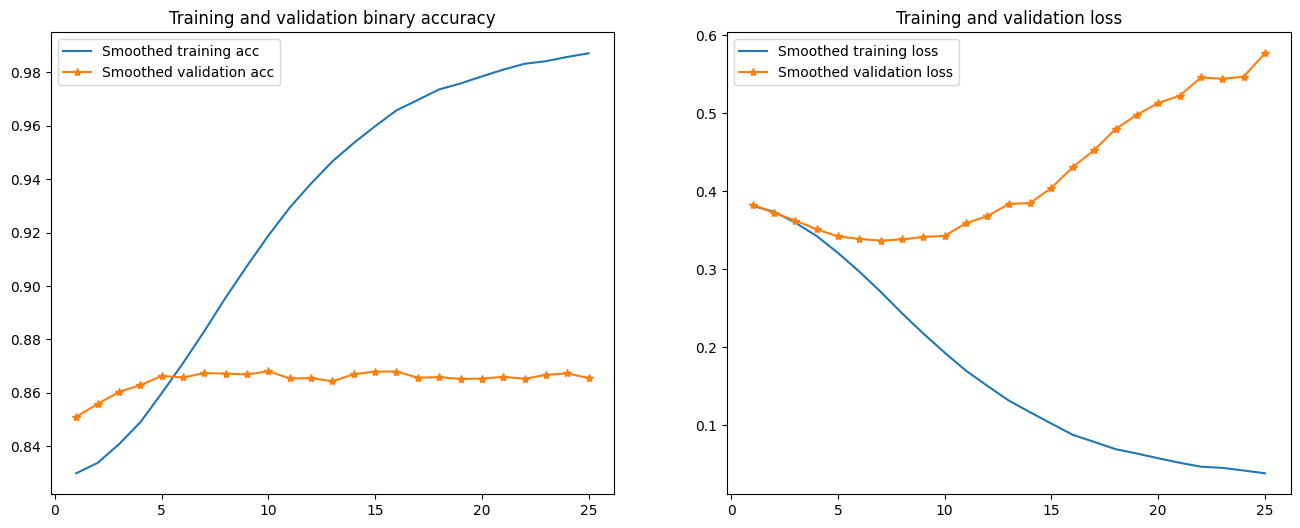

In [ ]:
plot_history_acc_loss(history2)

###  <font color='#37665f'>CNN adding Batch Normalization</font>

With the above experiments, we can see that the model is not learning, training and validation curves are not getting closer.

We are trying to include Batch Normalization.

In [39]:
model3 = Sequential([
          Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE ,CHANNELS)),
          BatchNormalization(),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(64, (3,3), activation='relu'),
          BatchNormalization(),
          Dropout(0.2),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(128, (3,3), activation='relu'),
          BatchNormalization(),
          Dropout(0.2),
          MaxPooling2D(pool_size=(2,2)),
          Flatten(),
          Dense(64, activation='relu'),
          Dropout(0.1),
          Dense(N_LABELS, activation='sigmoid')
          ])

model3.compile('adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                      

In [40]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
check_point = keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODELS_PATH, 'model_3.h5'), monitor='val_loss', save_best_only=True)

history3 = model3.fit(train_generator,
                      epochs=EPOCHS,
                      validation_data=test_generator,
                      callbacks=[early_stop, check_point])

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.7053 - binary_accuracy: 0.7687

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 12s 59ms/step - loss: 0.7036 - binary_accuracy: 0.7691 - val_loss: 12.4524 - val_binary_accuracy: 0.3510
Epoch 2/100
100/100 [==============================] - 8s 79ms/step - loss: 0.4714 - binary_accuracy: 0.8065 - val_loss: 4.8853 - val_binary_accuracy: 0.5780
Epoch 3/100
100/100 [==============================] - 7s 65ms/step - loss: 0.4274 - binary_accuracy: 0.8323 - val_loss: 1.2845 - val_binary_accuracy: 0.7090
Epoch 4/100
100/100 [==============================] - 6s 56ms/step - loss: 0.4076 - binary_accuracy: 0.8301 - val_loss: 1.4091 - val_binary_accuracy: 0.7485
Epoch 5/100
100/100 [==============================] - 5s 54ms/step - loss: 0.3794 - binary_accuracy: 0.8464 - val_loss: 0.7967 - val_binary_accuracy: 0.7630
Epoch 6/100
100/100 [==============================] - 6s 59ms/step - loss: 0.3630 - binary_accuracy: 0.8535 - val_loss: 0.7265 - val_binary_accuracy: 0.8005
Epoch 7/100
100/100 [==============================] - 8s 78ms

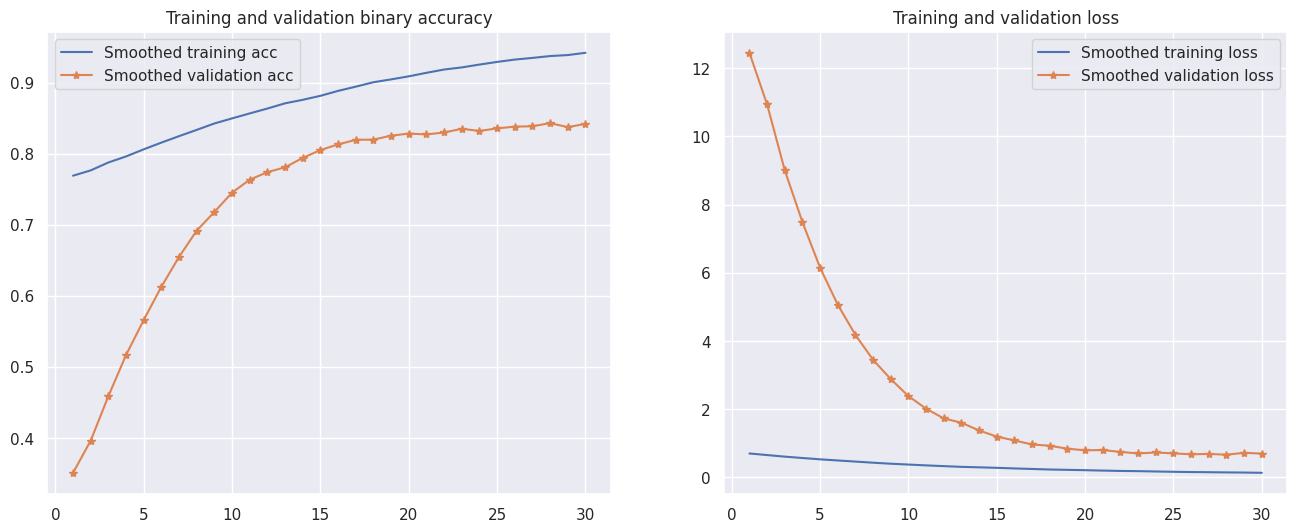

In [41]:
plot_history_acc_loss(history3)

###  <font color='#37665f'>CNN adding Data Augmentation</font>

By introducing Batch Normalization in the previous example, we can observe that the model starts learning from the data.

Since the dataset is small, we are also trying to perform **Data Augmentation** on training set. For this reason, we create a new ImageDataGenerator, with augmentation paramerers. We only perform augmenteation in df_train dataset and not in validation.

In [21]:
train_image_generator_aug = ImageDataGenerator(rescale=1./255,
                                               rotation_range=30,
                                               zoom_range=0.20,
                                               horizontal_flip=True,
                                               width_shift_range=0.2,
                                               height_shift_range=0.2,
                                               shear_range=0.15) # Generator for training data with augmentation

train_generator_aug = train_image_generator_aug.flow_from_dataframe(dataframe=df_train,
                                                            directory=IMG_PATH,
                                                            x_col='filename',
                                                            y_col='labels',
                                                            class_mode='categorical',
                                                            shuffle=True,
                                                            target_size=(IMG_SIZE,IMG_SIZE),
                                                            batch_size=BATCH_SIZE,
                                                            seed=13)

Found 1600 validated image filenames belonging to 5 classes.


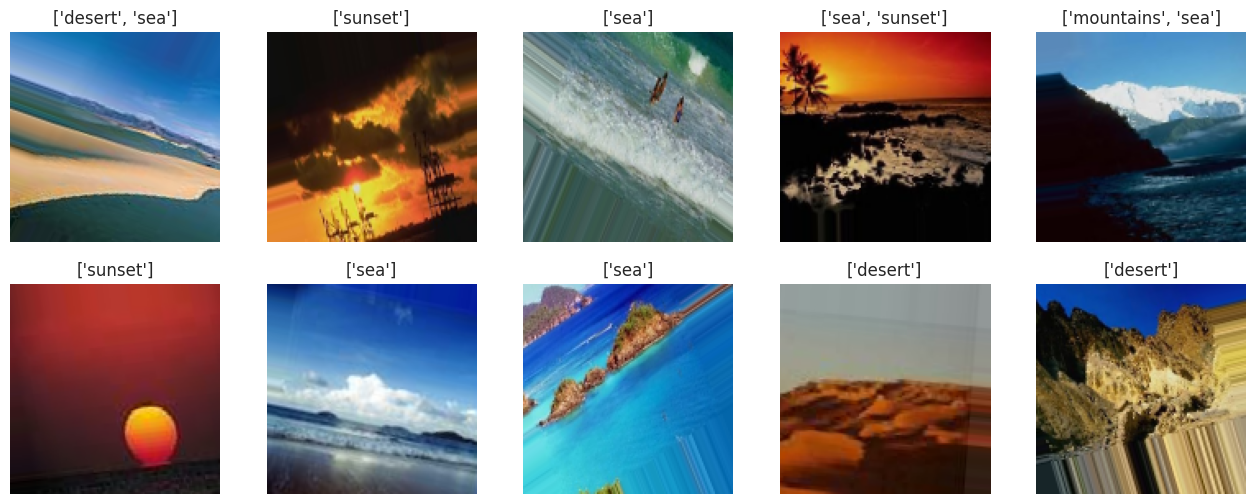

In [34]:
plt.figure(figsize=(16,6))
for image, label in train_generator_aug:
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(image[i])
        plt.title([label for label, truth in zip(label_names, label[i]) if truth==1])
        plt.axis('off')
    break

In [22]:
model4 = Sequential([
          Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE ,CHANNELS)),
          BatchNormalization(),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(64, (3,3), activation='relu'),
          BatchNormalization(),
          Dropout(0.2),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(128, (3,3), activation='relu'),
          BatchNormalization(),
          Dropout(0.2),
          MaxPooling2D(pool_size=(2,2)),
          Flatten(),
          Dense(64, activation='relu'),
          Dropout(0.1),
          Dense(N_LABELS, activation='sigmoid')
          ])

model4.compile('adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
check_point = keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODELS_PATH, 'model_4.h5'), monitor='val_loss', save_best_only=True)

history4 = model4.fit(train_generator_aug,
                      epochs=EPOCHS,
                      validation_data=test_generator,
                      callbacks=[early_stop, check_point])

Epoch 1/100
100/100 [==============================] - 461s 5s/step - loss: 0.7074 - binary_accuracy: 0.7413 - val_loss: 5.0925 - val_binary_accuracy: 0.6035
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 13s 130ms/step - loss: 0.5820 - binary_accuracy: 0.7639 - val_loss: 1.3537 - val_binary_accuracy: 0.7450
Epoch 3/100
100/100 [==============================] - 14s 137ms/step - loss: 0.5338 - binary_accuracy: 0.7751 - val_loss: 0.8842 - val_binary_accuracy: 0.7385
Epoch 4/100
100/100 [==============================] - 14s 136ms/step - loss: 0.4836 - binary_accuracy: 0.7872 - val_loss: 0.6092 - val_binary_accuracy: 0.7675
Epoch 5/100
100/100 [==============================] - 13s 129ms/step - loss: 0.4690 - binary_accuracy: 0.7916 - val_loss: 0.4857 - val_binary_accuracy: 0.7870
Epoch 6/100
100/100 [==============================] - 12s 119ms/step - loss: 0.4453 - binary_accuracy: 0.8021 - val_loss: 0.5152 - val_binary_accuracy: 0.7890
Epoch 7/100
100/100 [==============================] - 14s 144ms/step - loss: 0.4390 - binary_accuracy: 0.8014 - val_loss: 0.3814 - val_binary_accuracy: 0.8190
Epoch 8/100
100/100 [==============================]

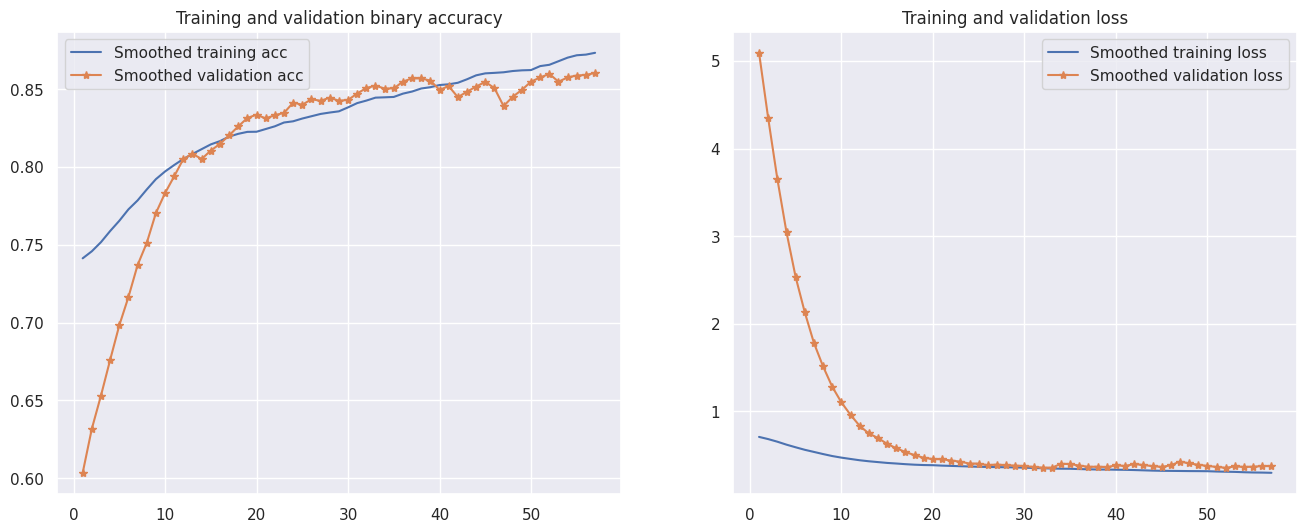

In [26]:
plot_history_acc_loss(history4)

In [14]:
# model4 = load_model(os.path.join(MODELS_PATH, 'model_4.h5'))

###  <font color='#37665f'>Final CNN Evaluation</font>

Get ground truth value

In [89]:
# Get ground truth labels
y_test = np.zeros((len(test_generator.labels), len(test_generator.class_indices)))
for i, label in enumerate(test_generator.labels):
  y_test[i, label] = 1


Score test dataset using the last CNN model we developed from scratch

In [97]:
# Get predicted probabilities
test_probs = model4.predict(test_generator)

# Transform probabilities into 1/0 values for each label,
# if probability is greater than 0.5
y_pred = np.array([[1 if test_probs[i,j]>=0.5 else 0
                    for j in range(test_probs.shape[1])] for i in range(test_probs.shape[0])])

25/25 [==============================] - 1s 38ms/step


Evaluate predictions

In [98]:
# Classification Report
print('CNN classifier:\n')
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=label_names, zero_division=1))

CNN classifier:

              precision    recall  f1-score   support

      desert       0.88      0.71      0.78        85
   mountains       0.74      0.80      0.76        98
         sea       0.77      0.44      0.56       112
      sunset       0.92      0.81      0.86        83
       trees       0.83      0.75      0.79       115

   micro avg       0.82      0.69      0.75       493
   macro avg       0.83      0.70      0.75       493
weighted avg       0.82      0.69      0.74       493
 samples avg       0.85      0.73      0.74       493



We can see that the avg. F1 score is 0.75, that is much higher than the dummy classifier, which had 0.21

Print predictions:

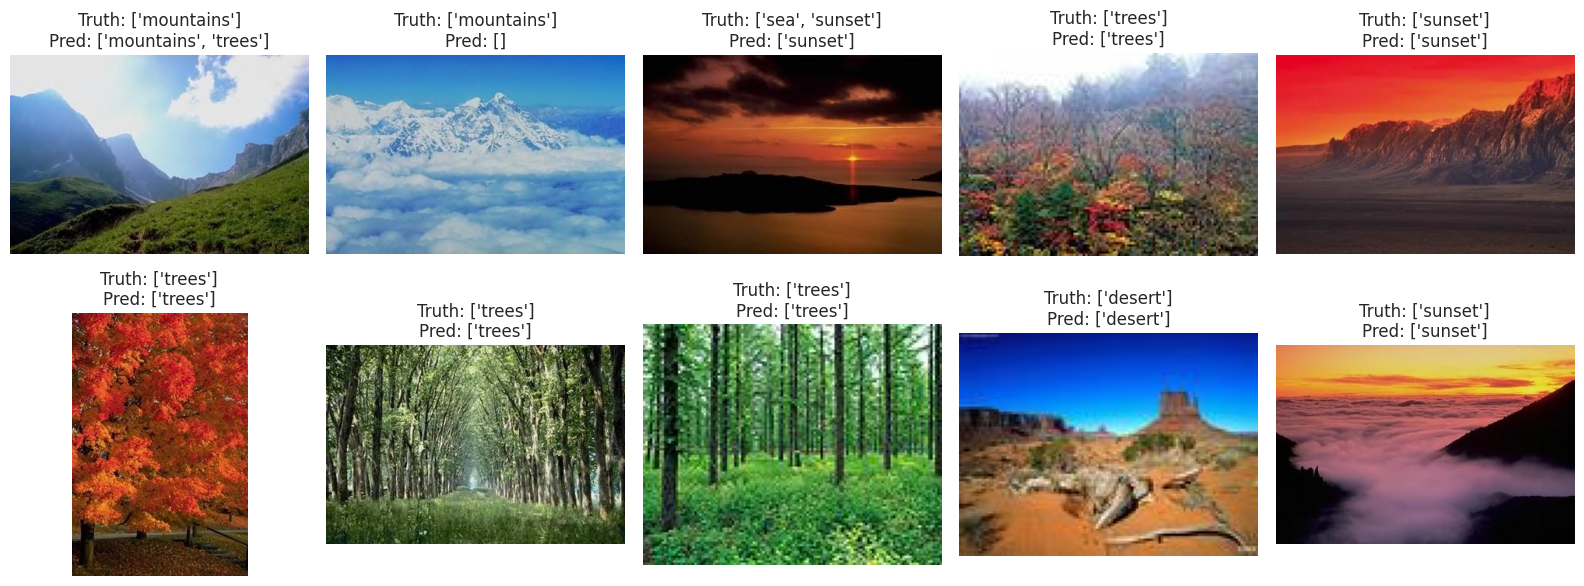

In [59]:
plt.figure(figsize=(16,6))
for i, r in df_test[:10].iterrows():
  plt.subplot(2,5,i+1)
  img = plt.imread(os.path.join(IMG_PATH, r['filename']))
  plt.imshow(img)
  plt.title('Truth: {}\nPred: {}'.format(r['labels'],
            [label for label, truth in zip(label_names, y_pred[i]) if truth==1]))
  plt.axis('off')
plt.tight_layout()

Predict labels on own images not in dataset, some of them are arbitrary.

In [ ]:
VAL_PATH = '/content/drive/MyDrive/natural_scene_miml_image_data/val_folder/'

val_image_generator = ImageDataGenerator(rescale=1./255)

val_generator = val_image_generator.flow_from_directory(directory=VAL_PATH,
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        target_size=(IMG_SIZE,IMG_SIZE),
                                                        batch_size=BATCH_SIZE,
                                                        seed=13)

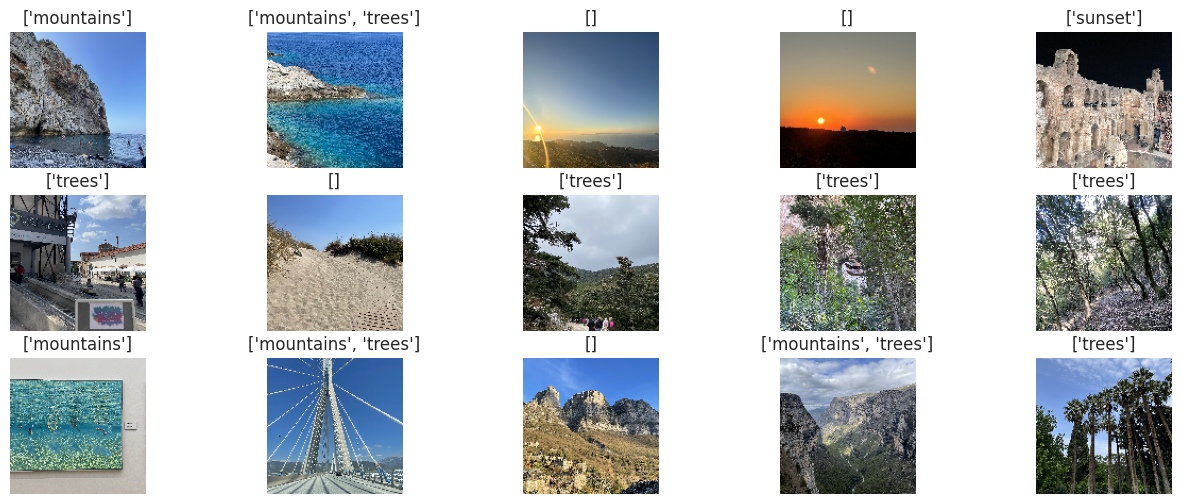

In [107]:
val_probs = model.predict(val_generator)

val_pred = np.array([[1 if val_probs[i,j]>=0.5 else 0
                    for j in range(val_probs.shape[1])] for i in range(val_probs.shape[0])])

plt.figure(figsize=(16,6))
for image, label in val_generator:
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.imshow(image[i])
        plt.title([label for label, truth in zip(label_names, val_pred[i]) if truth==1])
        plt.axis('off')
    break

As we can see, in images from different dataset, model is not performing as in initial dataset.

###  <font color='#37665f'>Transfer Learning</font>

At this section, we are trying ResNet50 pretrained model, in order to apply Transfer Learning. We are using its weights but we are training the fully connected part using our data. For the optimizer we are going to use a very small learning rate.

In [116]:
from tensorflow.keras.applications.resnet50 import ResNet50

# Load ResNet50 model without the last dense layer
res_model = ResNet50(input_shape=(IMG_SIZE,IMG_SIZE,3) , weights='imagenet' , include_top = False)

# Freeze all layers before dense layer
for layer in res_model.layers:
        layer.trainable = False

In [121]:
# Add Dense layers in ResNet model
model5 = Sequential()
model5.add(res_model)
model5.add(Flatten())
model5.add(BatchNormalization())
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.25))
model5.add(BatchNormalization())
model5.add(Dense(N_LABELS, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
check_point = keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODELS_PATH, 'model_5.h5'), monitor='val_loss', save_best_only=True)

history5 = model5.fit(train_generator_aug,
                      epochs=EPOCHS,
                      validation_data=test_generator,
                      callbacks=[early_stop, check_point])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.6402 - binary_accuracy: 0.6594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 25s 203ms/step - loss: 0.6402 - binary_accuracy: 0.6594 - val_loss: 0.7357 - val_binary_accuracy: 0.5165
Epoch 2/100
100/100 [==============================] - 16s 156ms/step - loss: 0.5310 - binary_accuracy: 0.7429 - val_loss: 0.6183 - val_binary_accuracy: 0.6685
Epoch 3/100
100/100 [==============================] - 16s 163ms/step - loss: 0.4811 - binary_accuracy: 0.7740 - val_loss: 0.4621 - val_binary_accuracy: 0.7920
Epoch 4/100
100/100 [==============================] - 16s 160ms/step - loss: 0.4606 - binary_accuracy: 0.7895 - val_loss: 0.4171 - val_binary_accuracy: 0.8075
Epoch 5/100
100/100 [==============================] - 13s 128ms/step - loss: 0.4506 - binary_accuracy: 0.7957 - val_loss: 0.4360 - val_binary_accuracy: 0.8055
Epoch 6/100
100/100 [==============================] - 13s 133ms/step - loss: 0.4465 - binary_accuracy: 0.7904 - val_loss: 0.4585 - val_binary_accuracy: 0.7975
Epoch 7/100
100/100 [==============================]

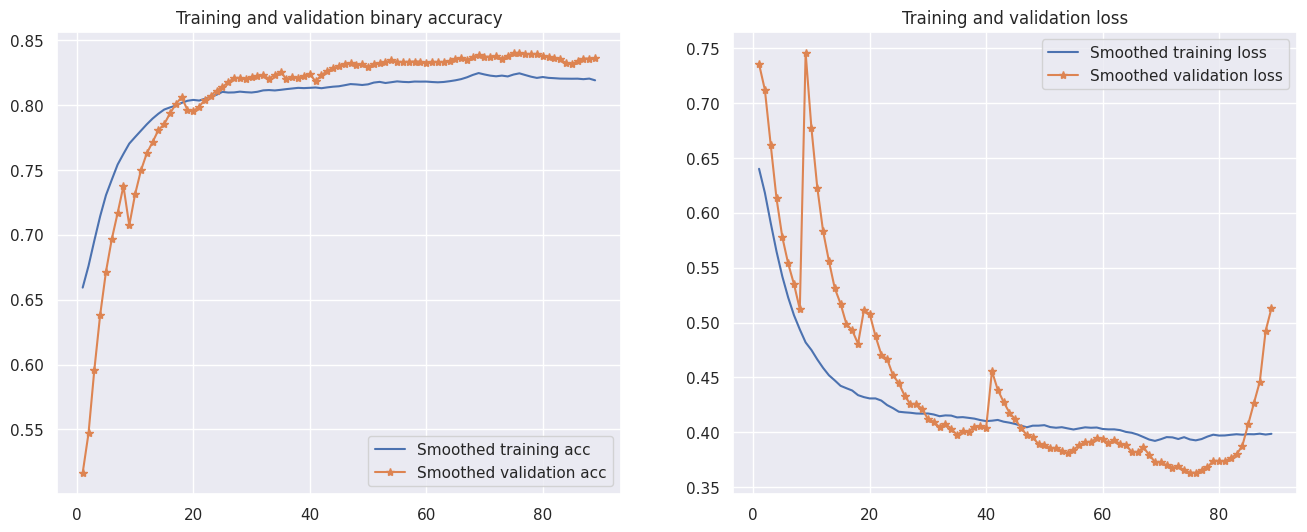

In [122]:
plot_history_acc_loss(history5)

Evaluation

In [123]:
# Get ground truth labels
y_test = np.zeros((len(test_generator.labels), len(test_generator.class_indices)))
for i, label in enumerate(test_generator.labels):
  y_test[i, label] = 1

# Get predicted probabilities
test_probs = model5.predict(test_generator)

# Transform probabilities into 1/0 values for each label,
# if probability is greater than 0.5
y_pred = np.array([[1 if test_probs[i,j]>=0.5 else 0
                    for j in range(test_probs.shape[1])] for i in range(test_probs.shape[0])])

# Classification Report
print('ResNet50 classifier:\n')
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=label_names, zero_division=1))

25/25 [==============================] - 2s 46ms/step
ResNet50 classifier:

              precision    recall  f1-score   support

      desert       0.73      0.55      0.63        85
   mountains       0.70      0.48      0.57        98
         sea       0.63      0.30      0.41       112
      sunset       0.91      0.72      0.81        83
       trees       0.81      0.69      0.74       115

   micro avg       0.77      0.54      0.63       493
   macro avg       0.76      0.55      0.63       493
weighted avg       0.75      0.54      0.62       493
 samples avg       0.82      0.56      0.57       493



The average F1 score of the transfered model is 0.63, lower comparing to the CNN we developed from scratch. This may caused because the training data were not enough to train the Dense layer of the ResNet, or we should unfroze more layers.